# Introduction

Why we use a [Jupyter](https://en.wikipedia.org/wiki/Project_Jupyter) notebook to to publish the R program examples:

Jupyter is a new **open source** alternative to the proprietary numerical software [Mathematica](https://en.wikipedia.org/wiki/Wolfram_Mathematica) from **Wolfram Research** that is well on the way to become a **standard for exchanging research results** (<cite data-cite="Scientific_Paper_obsolete_2018">Somers, 2018</cite>; <cite data-cite="Future_of_Research_Paper_2018">Romer, 2018</cite>).

Originally Jupyter was intended as an IDE for the programming languages **Julia** and **Python**. Besides that it is also possible to install other interpreter kernels, such as the **[IRkernel](https://irkernel.github.io/installation/)** for R. This can be interesting if the IDE **RStudio Desktop** is not available on the target platform used. For example, it is very difficult to install RStudio on the ARM-based embedded computer **Raspberry Pi** due to many technical dependencies. In contrast, using the R kernel in JupyterLab on the Raspberry Pi works very well and performant.

# Global settings and dependencies

## Install missing packages if not present yet

**Attention:** For some R packages several dependencies have to be installed first with `apt install <package name>`.

Dependencies for package `ahpsurvey`:  
- R package `randomNames` (it depends on R ≥ 4.0, refer to [https://cran.r-project.org/web/packages/randomNames/index.html](https://cran.r-project.org/web/packages/randomNames/index.html))

Drawback for **Raspbian buster**: the dependency `randomNames` is not available for R v3.5.2 as it depends on R (≥ 4.0). Upgrading R in Raspbian following the instruction on [https://cran.rstudio.com/bin/linux/debian/#debian-buster-stable](https://cran.rstudio.com/bin/linux/debian/#debian-buster-stable) does not work so far ...

In [1]:
# List of R packages that are used in this script
list.of.packages <- c("data.table", "ggplot2", "tidyr", "dplyr", "magrittr", "ahpsurvey")

# Query the already installed packages and save the missing ones in a new list
missing.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]

# Install missing packages
if(length(missing.packages)) {
    install.packages(missing.packages)
} else {
    print("All required packages are installed.")
}

[1] "All required packages are installed."


## Load package `data.table`

The package `data.table` is used to read and manipulate tables (`data.table` inherits from `data.frame`). Install and load it:

In [2]:
library(data.table)

## Load package `ggplot2`

The package `ggplot2` is used to plot diagrams. Install and load it:

In [3]:
library(ggplot2)

## Load package `tidyr`

The package `tidyr` is used to **reshape** the dataframes and provides functions like `gather()` or `spread()`. Some examples for the application can be found here: [Reshaping Your Data with tidyrReshaping Your Data with tidyr](https://uc-r.github.io/tidyr).

Install and load it:

In [4]:
library(tidyr)

## Load package `dplyr`

The package `dplyr` is necessary to manipulate dataframes using functions like `select()`, `mutate()` and `left_join()`. Install and load it:

**Hint:** Setting the parameter `warn.conflicts=FALSE` when calling the `library()` function silences annoying messages about masked functions.

In [5]:
library(dplyr, warn.conflicts=FALSE)

## Use pipes for better coding

**HINT:** The pipe functionality is already available by loading the library `tidyr` - so you don't have to load it explicitly.

What pipes like `%>%` are and how to use them is described here: [https://statistik-dresden.de/archives/15679](https://statistik-dresden.de/archives/15679).

Before using pipes in R, you have to install and load the package `magrittr`:

In [6]:
library(magrittr, warn.conflicts=FALSE)

## Load package `ahpsurvey`

The package `ahpsurvey` contains all the necessary mathematical and statistical methods to run the analytical hierarchy process (AHP).

In [7]:
library(ahpsurvey)

# Functions for processing AHP

## Set globally used input and output folders

In [8]:
str_input_path = "./output_data_manipulated"
str_output_path = "./output_data_AHP"

## Function to read in the processed survey data from CSV files to dataframes

Define a function for reading in a CSV file to a date frame.

In [9]:
func_readCSVdata_to_dataframe <- function(str_CSVfilename) {
  
  df_CSVdata <- fread(
    file = str_CSVfilename, encoding = "UTF-8",
    header = TRUE, sep = "\t", quote = "\""
    )
  
  return(df_CSVdata)
}

## Function for generating a data frame with *eigentrue values* (weights)

In [10]:
func_genEigentrue_to_dataframe <- function(df_surveyData, vec_attributes) {
  list_mat_judgement <- df_surveyData %>% 
    ahp.mat(vec_attributes, negconvert = TRUE)
  
  df_eigentrue <- ahp.indpref(list_mat_judgement, vec_attributes, method = "eigen")

  return(df_eigentrue)
}

## Function for generating an array with consistency ratios

In [11]:
func_genCR_to_arr <- function(df_surveyData, vec_attributes) {
  arr_cr <- df_surveyData %>%
    ahp.mat(vec_attributes, negconvert = TRUE) %>% 
    ahp.cr(vec_attributes, ri=0.58)

  return(arr_cr)
}

## Function for generating a data frame with consistency ratios

In [12]:
func_genCR_to_dataframe <- function(df_surveyData, vec_attributes, arr_cr, consistency_thres=0.1, str_CRlabel) {
  df_cr <- df_surveyData %>%
    ahp.mat(vec_attributes, negconvert = TRUE) %>% 
    ahp.cr(vec_attributes, ri=0.58) %>% 
    data.frame() %>%
    mutate(rowid = 1:length(arr_cr), arr_cr.dum = as.factor(ifelse(arr_cr <= consistency_thres, 1, 0)))
  
  # rename column with consistency ratios
  colnames(df_cr)[1] <- str_CRlabel

  return(df_cr)
}

## Function for visualizing individual priorities and consistency ratios

In [13]:
func_visuPriosCRs <- function(df_surveyData, df_cr, arr_cr, consistency_thres=0.1, vec_attributes, df_eigentrue, vec_labels, str_image_filename) {
  df_cr_sel <- df_cr %>%
    select(arr_cr.dum, rowid)

  plot <- df_surveyData %>%
      ahp.mat(atts = vec_attributes, negconvert = TRUE) %>% 
      ahp.indpref(vec_attributes, method = "eigen") %>% 
      mutate(rowid = 1:nrow(df_eigentrue)) %>%
      left_join(df_cr_sel, by = 'rowid') %>%
      gather(all_of(vec_attributes), key = "var", value = "pref") %>%
      ggplot(aes(x = var, y = pref)) + 
      geom_violin(alpha = 0.6, width = 0.8, color = "transparent", fill = "gray") +
      geom_jitter(alpha = 0.6, height = 0, width = 0.1, aes(color = arr_cr.dum)) +
      geom_boxplot(alpha = 0, width = 0.3, color = "#808080") +
      scale_x_discrete("Attribute", label = vec_labels) +
      scale_y_continuous("Weight (dominant eigenvalue)", 
                         labels = scales::percent, 
                         breaks = c(seq(0,0.7,0.1))) +
      guides(color=guide_legend(title=NULL))+
      scale_color_discrete(breaks = c(0,1), 
                           labels = c(paste("CR >", consistency_thres), 
                                      paste("CR <", consistency_thres))) +
      labs(NULL, caption = paste("n =", nrow(df_surveyData), ",", "Mean CR =",
                               round(mean(arr_cr),3))) +
      theme_minimal() +
      ggtitle("Violins displaying priorities and consistency ratios")

  # save generated ggplot graphic to a PNG image file
  ggsave(filename = str_image_filename, width = 7, height = 7, dpi = 300)

  print(plot)
}

## Function for generating geometric mean values from individual judgement matrices

In [14]:
func_aggpref_gmean <- function(df_surveyData, vec_attributes, arr_cr, consistency_thres=0.1, str_CRlabel) {
  df_cr <- df_surveyData %>%
    ahp.mat(vec_attributes, negconvert = TRUE) %>% 
    ahp.cr(vec_attributes, ri=0.58) %>% 
    data.frame() %>%
    mutate(rowid = 1:length(arr_cr), arr_cr.dum = as.factor(ifelse(arr_cr <= consistency_thres, 1, 0)))
  
  # rename column with consistency ratios
  colnames(df_cr)[1] <- str_CRlabel

  # combine data frame 'df_cr' with raw survey data ('df_surveyData')
  df_cr_wRaw <- cbind(df_cr, df_surveyData)
  
  # remove rows, where 'arr_cr.dum' == 0 (inconsistent data)
  df_cr_wRaw_cons <- df_cr_wRaw[df_cr_wRaw$arr_cr.dum != 0, ]
  
  # get individual judgement matrices from last 3 columns
  list_mat_judgement <- df_cr_wRaw_cons[tail(names(df_cr_wRaw_cons), 3)] %>% 
    ahp.mat(vec_atts, negconvert = TRUE)
  
  # get geometric mean values from judgement matrices
  list_gmean_l <- ahp.aggpref(list_mat_judgement, vec_atts, method = "eigen", aggmethod = "geometric")
  
  return(list_gmean_l)
}

## Function for normalizing the geometric mean values

In [15]:
func_norm_gmean <- function(list_gmeans) {
  # normalization so that the sum of the geometric mean values is 1 (corresponds to 100%)
  df_gmean_l <- data.frame(list_gmeans)
  # rename column with geometric mean values (raw)
  colnames(df_gmean_l)[1] <- "gmean.raw"
  
  gmean_sum <- 0
  for ( val in list_gmeans ) {
    gmean_sum <- gmean_sum + val
  }
  df_gmean_l["Sum", 1] <- gmean_sum
  
  for (idx in 1:length(list_gmeans)) {
    gmean_norm <- list_gmeans[[idx]] / gmean_sum
    df_gmean_l[idx, "gmean.norm"] <- gmean_norm
  }
  
  gmean_sum_norm <- 0
  # iterate over all rows except the last, because this is the sum itself
  for ( row in 1:(nrow(df_gmean_l)-1) ) {
    gmean_sum_norm <- gmean_sum_norm + df_gmean_l[row, 2]
  }
  df_gmean_l["Sum", 2] <- gmean_sum_norm
  
  return(df_gmean_l)
}

## Function to process the ahpsurvey and create violin plots

In [41]:
func_Process_ahpsurvey <- function(df_csvInputFiles, str_participants_group, str_input_path, str_output_path, df_attributes_labels) {
    row_start = 1
    row_end = 3

    df_outputTable <- data.table()

    for ( file_idx in 1:nrow(df_csvInputFiles) ) {
        # create data frame from current input CSV file
        str_filename <- paste(str_input_path, df_csvInputFiles[file_idx, filenames], sep="/")
        df_processed_survey_data <- func_readCSVdata_to_dataframe(str_filename)

        # create vectors for attributes and labels from a subset of data frame 'df_attributes_labels_XXX'
        vec_atts <- df_attributes_labels[c(row_start:row_end), attr]
        vec_labels <- df_attributes_labels[c(row_start:row_end), labels]
        # shift row interval for next iteration
        row_start = row_start + 3
        row_end = row_end + 3

        # generate data frame with eigentrue values (weights) 
        df_eigentrue_weights <- func_genEigentrue_to_dataframe(df_processed_survey_data, vec_atts)

        # generate an array with consistency ratios
        arr_CRs <- func_genCR_to_arr(df_processed_survey_data, vec_atts)

        # generate a extended data frame with consistency ratios
        consistency_thres = 0.1
        str_CRlabel <- paste("CR", df_csvInputFiles[file_idx, keys], sep="_")
        df_CRs <- func_genCR_to_dataframe(df_processed_survey_data, vec_atts, arr_CRs, consistency_thres, str_CRlabel)

        str_image_filename <- paste("ahp_violin", str_participants_group, df_csvInputFiles[file_idx, keys], sep="_")
        print(str_image_filename)
        str_image_filename <- paste(str_image_filename, ".png", sep="")
        str_image_filename <- paste(str_output_path, str_image_filename, sep="/")
        func_visuPriosCRs(df_processed_survey_data, df_CRs, arr_CRs, consistency_thres, vec_atts, df_eigentrue_weights, vec_labels, str_image_filename)

        # combine data frames of eigentrue values (weights) with consistency ratios
        df_outputTable <- cbind(df_outputTable, df_eigentrue_weights)
        # add only specific columns of 'df_CRs' (omit column 'row_id')
        df_outputTable <- cbind(df_outputTable, df_CRs[c(1, 3)])
    }

    # extend file name by path
    str_CSVfilename_output <- paste("rdata", str_participants_group, "eigentrue_CRs", sep="_")
    str_CSVfilename_output <- paste(str_CSVfilename_output, ".csv", sep="")
    str_CSVfilename_output <- paste(str_output_path, str_CSVfilename_output, sep="/")

    # write data frame 'df_outputTable' to CSV file
    write.table(df_outputTable, file = str_CSVfilename_output,
                fileEncoding = "UTF-8", row.names = FALSE,
                col.names = TRUE, sep = "\t", quote = TRUE)
}

# Create data frames (tables) handling the file names of processed survey data

## File table for all participants

In [16]:
df_csvInputFiles_all <- data.table(
  file_idx = 1:4,
  keys = c("env", "soc", "eco", "crit"),
  filenames = c("rdata_all_env_AHP_edible_Cities_2022-03-18_09-53.csv",
                "rdata_all_soc_AHP_edible_Cities_2022-03-18_09-53.csv",
                "rdata_all_eco_AHP_edible_Cities_2022-03-18_09-53.csv",
                "rdata_all_crit_AHP_edible_Cities_2022-03-18_09-53.csv"),
  descriptions = c("environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria",
                   "criteria (main criteria)")
)

## File table for city administrations

In [17]:
df_csvInputFiles_CA <- data.table(
  file_idx = 1:4,
  keys = c("env", "soc", "eco", "crit"),
  filenames = c("rdata_CA_env_AHP_edible_Cities_2022-03-18_10-28.csv",
                "rdata_CA_soc_AHP_edible_Cities_2022-03-18_10-28.csv",
                "rdata_CA_eco_AHP_edible_Cities_2022-03-18_10-28.csv",
                "rdata_CA_crit_AHP_edible_Cities_2022-03-18_10-28.csv"),
  descriptions = c("environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria",
                   "criteria (main criteria)")
)

## File table for non-governmental organizations

In [18]:
df_csvInputFiles_NGO <- data.table(
  file_idx = 1:4,
  keys = c("env", "soc", "eco", "crit"),
  filenames = c("rdata_NGO_env_AHP_edible_Cities_2022-03-18_10-40.csv",
                "rdata_NGO_soc_AHP_edible_Cities_2022-03-18_10-40.csv",
                "rdata_NGO_eco_AHP_edible_Cities_2022-03-18_10-40.csv",
                "rdata_NGO_crit_AHP_edible_Cities_2022-03-18_10-40.csv"),
  descriptions = c("environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria",
                   "criteria (main criteria)")
)

## File table for practitioners and experts

In [19]:
df_csvInputFiles_PE <- data.table(
  file_idx = 1:4,
  keys = c("env", "soc", "eco", "crit"),
  filenames = c("rdata_PE_env_AHP_edible_Cities_2022-03-18_10-41.csv",
                "rdata_PE_soc_AHP_edible_Cities_2022-03-18_10-41.csv",
                "rdata_PE_eco_AHP_edible_Cities_2022-03-18_10-41.csv",
                "rdata_PE_crit_AHP_edible_Cities_2022-03-18_10-41.csv"),
  descriptions = c("environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria",
                   "criteria (main criteria)")
)

# Exploit datasets of own survey with package `ahpsurvey` for each group of participants

In [29]:
df_attributes_labels <- data.table(
  idx = 1:12,
  attr = c("Clim", "BDiv", "CiEc",
           "KEdu", "Comm", "Part",
           "Qual", "LVCs", "Affo",
           "Envi", "Soci", "Econ"),
  labels = c("Microclimate and Hydrology", "Biodiversity", "Circular economy",
             "Knowledge and Education", "Community Building", "Participation",
             "Food Quality and Safety", "Local Value Chains", "Food Affordability",
             "Environment", "Society", "Economy")
)

## All participants

[1] "ahp_violin_all_env"
[1] "ahp_violin_all_soc"
[1] "ahp_violin_all_eco"


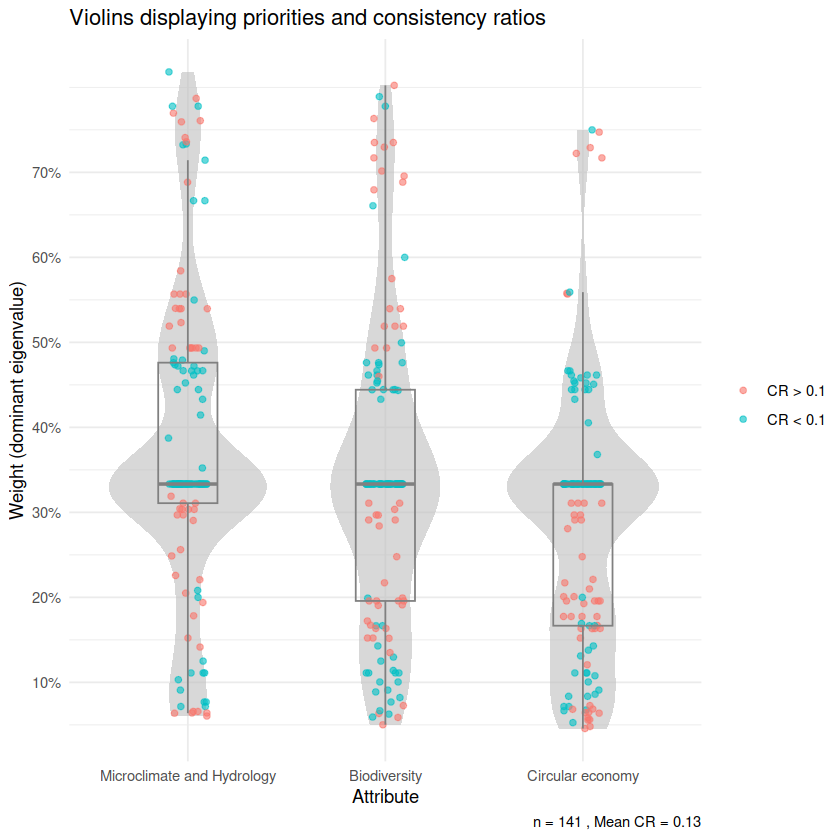

[1] "ahp_violin_all_crit"


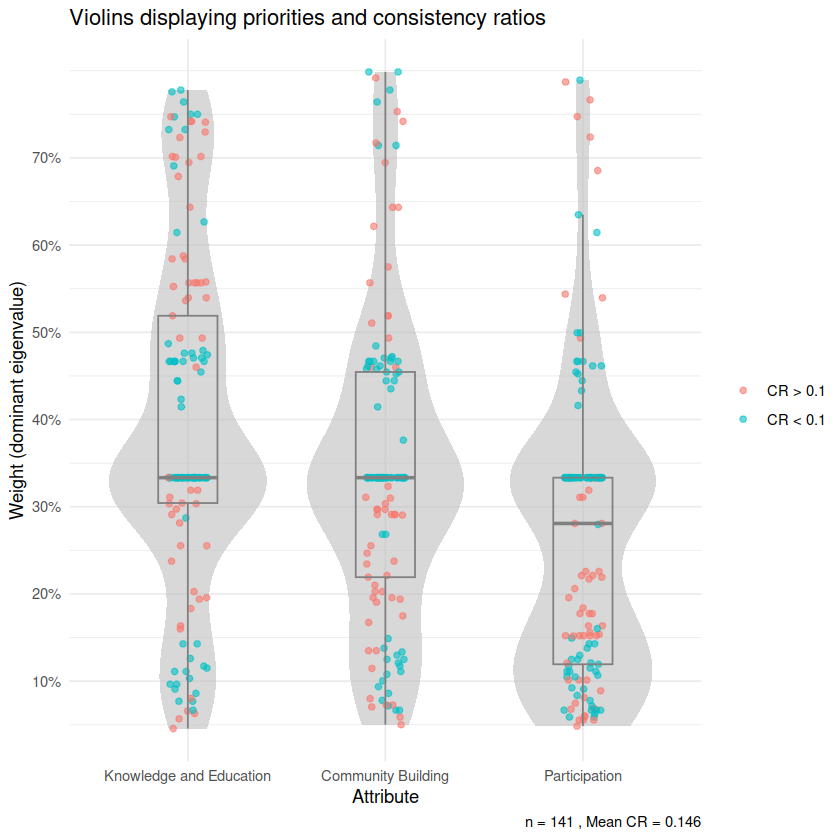

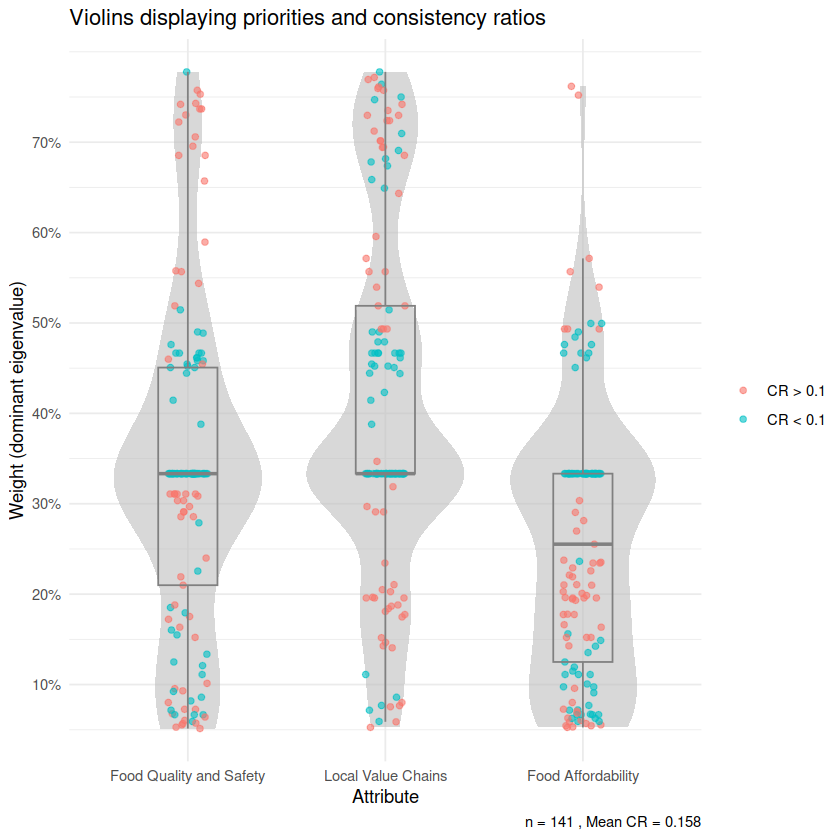

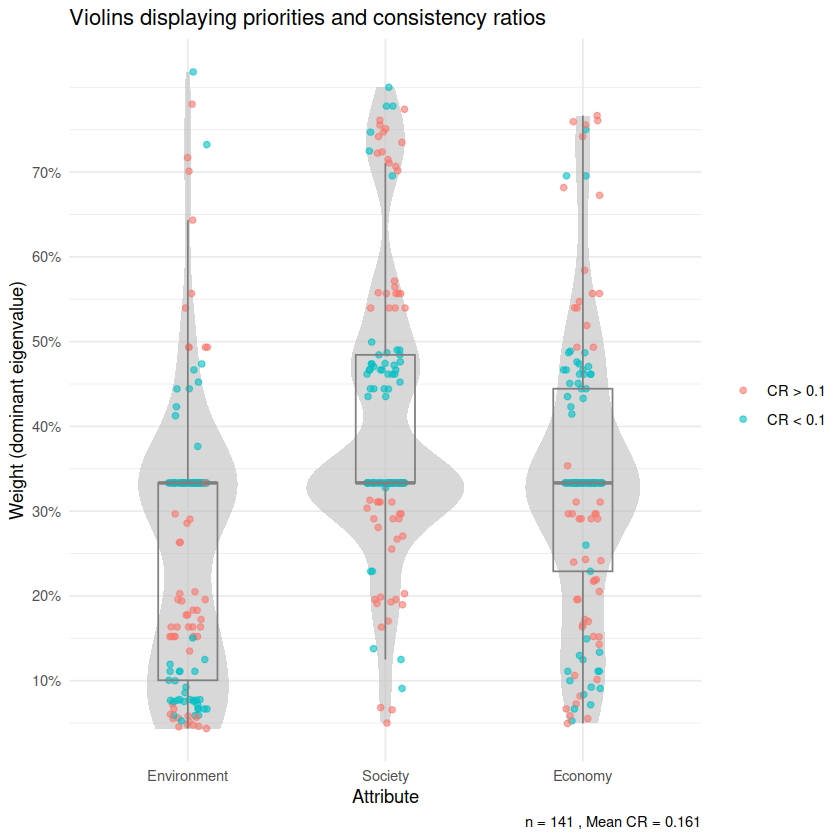

In [33]:
func_Process_ahpsurvey(df_csvInputFiles_all, "all", str_input_path, str_output_path, df_attributes_labels)

## Participants of city administrations

[1] "ahp_violin_CA_env"
[1] "ahp_violin_CA_soc"
[1] "ahp_violin_CA_eco"


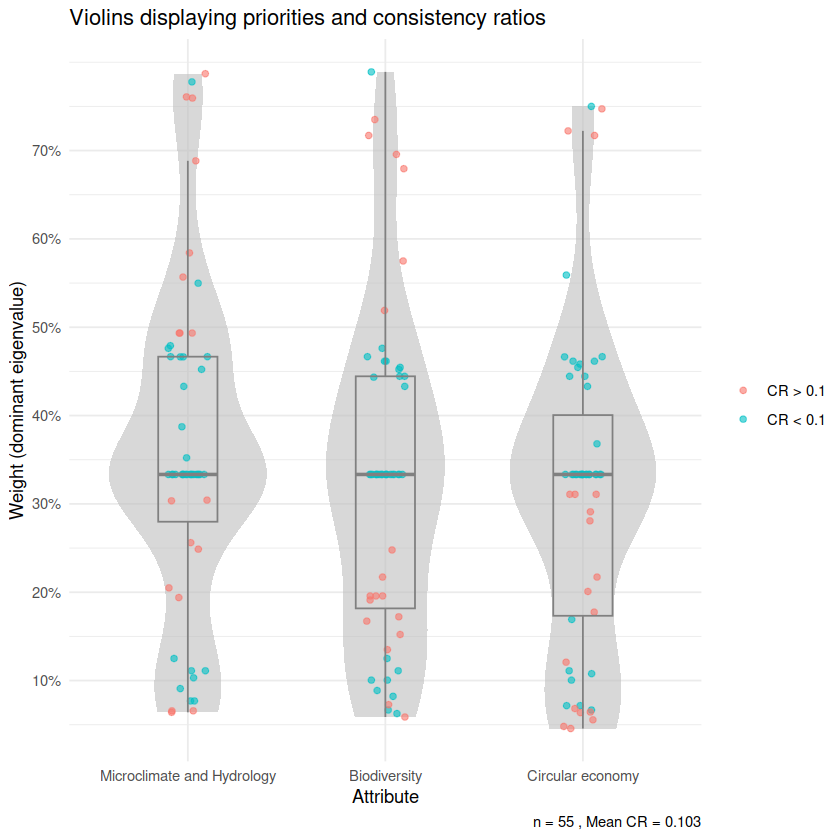

[1] "ahp_violin_CA_crit"


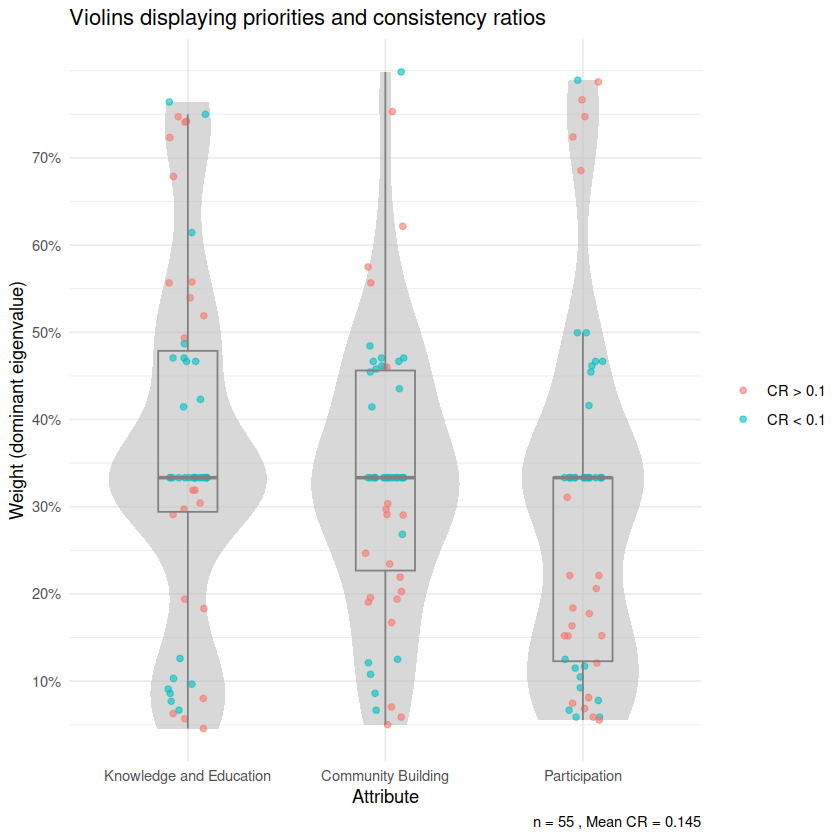

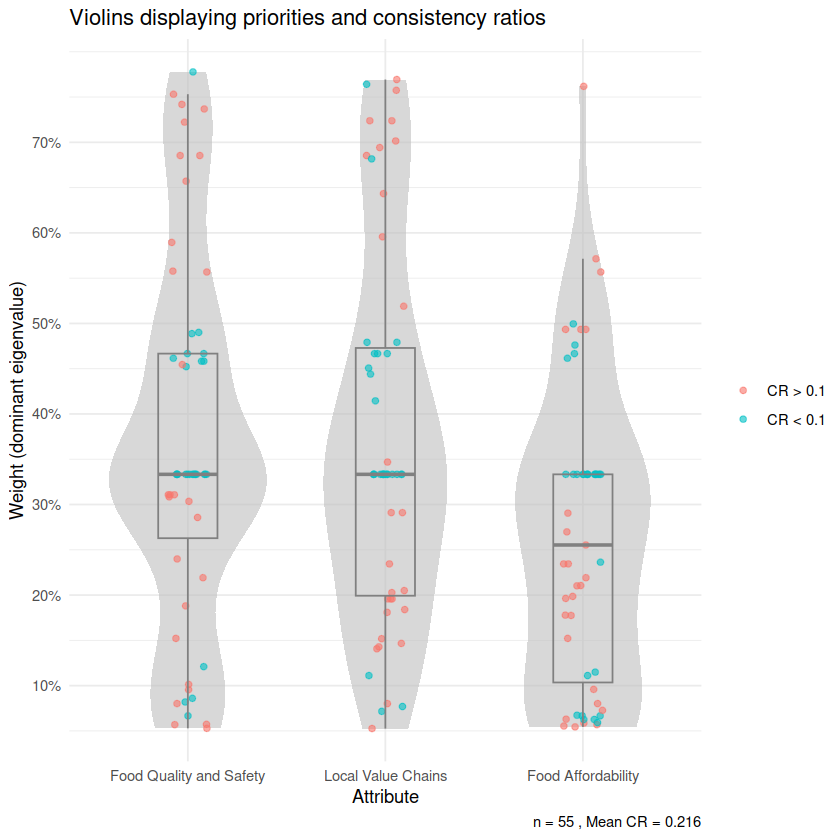

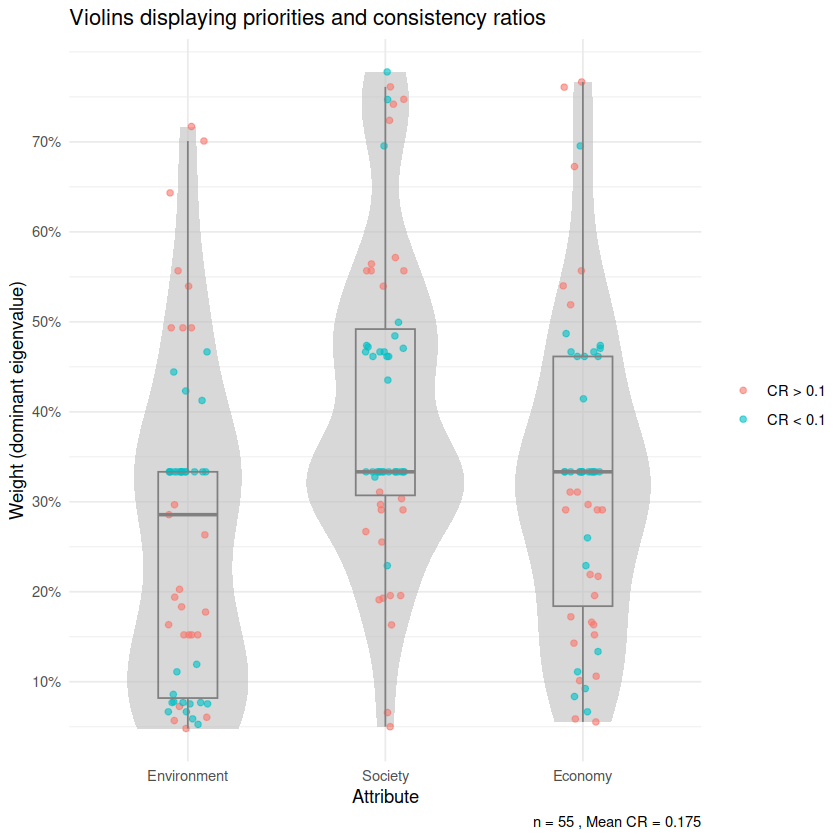

In [35]:
func_Process_ahpsurvey(df_csvInputFiles_CA, "CA", str_input_path, str_output_path, df_attributes_labels)

## Participants of non-governmental organizations

[1] "ahp_violin_NGO_env"
[1] "ahp_violin_NGO_soc"
[1] "ahp_violin_NGO_eco"


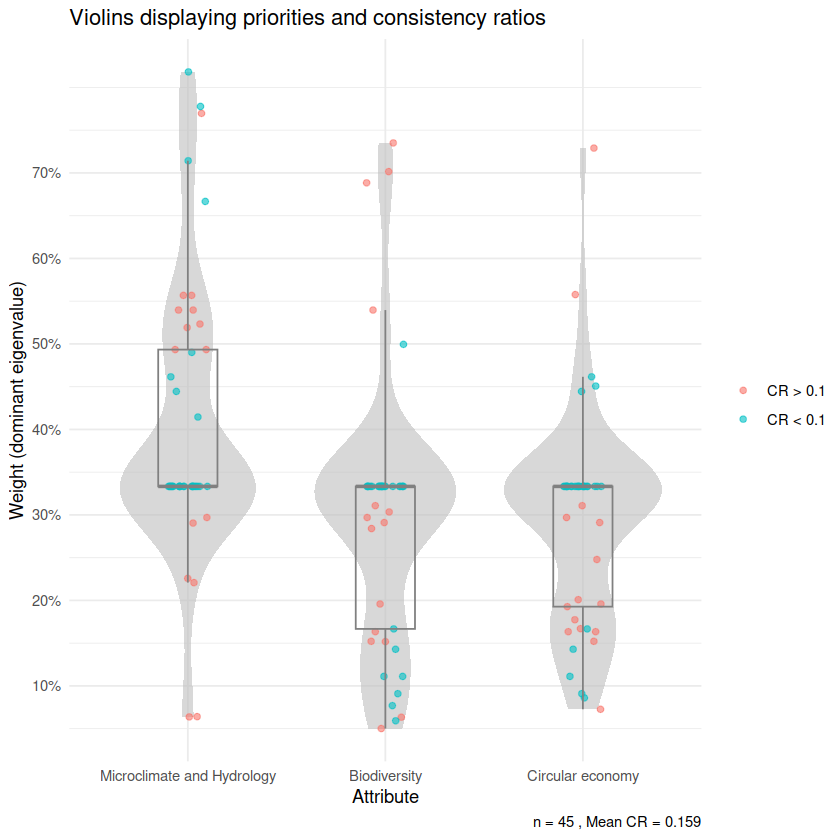

[1] "ahp_violin_NGO_crit"


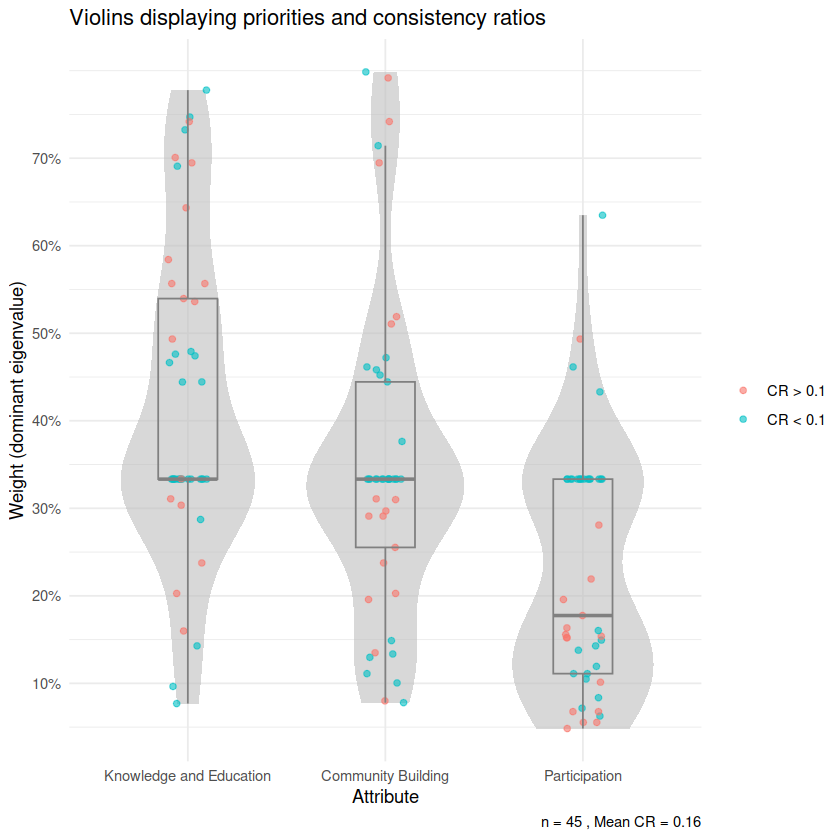

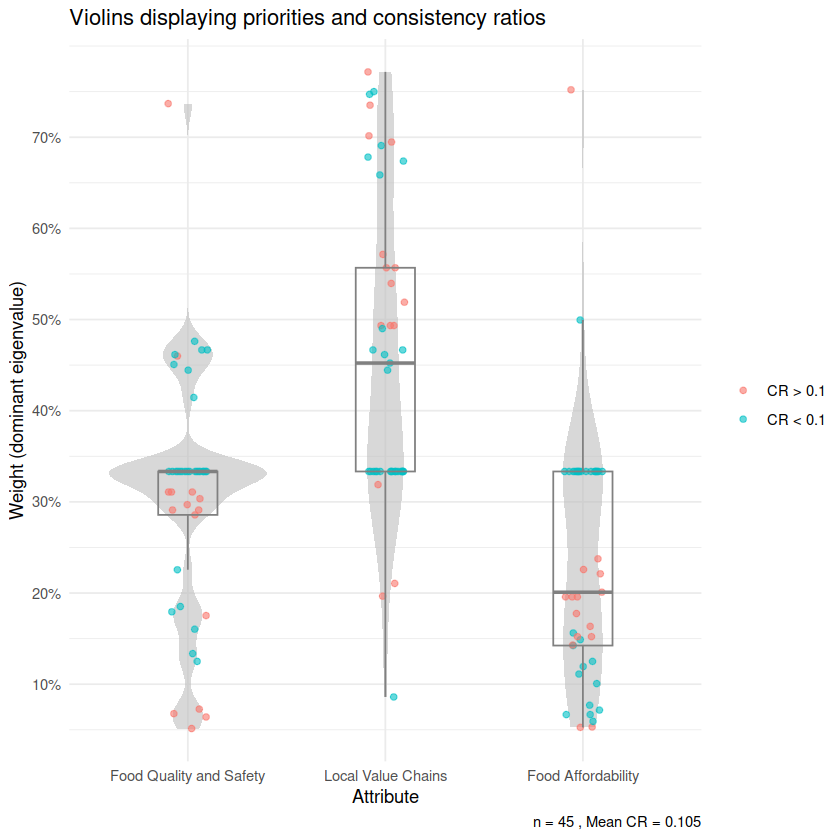

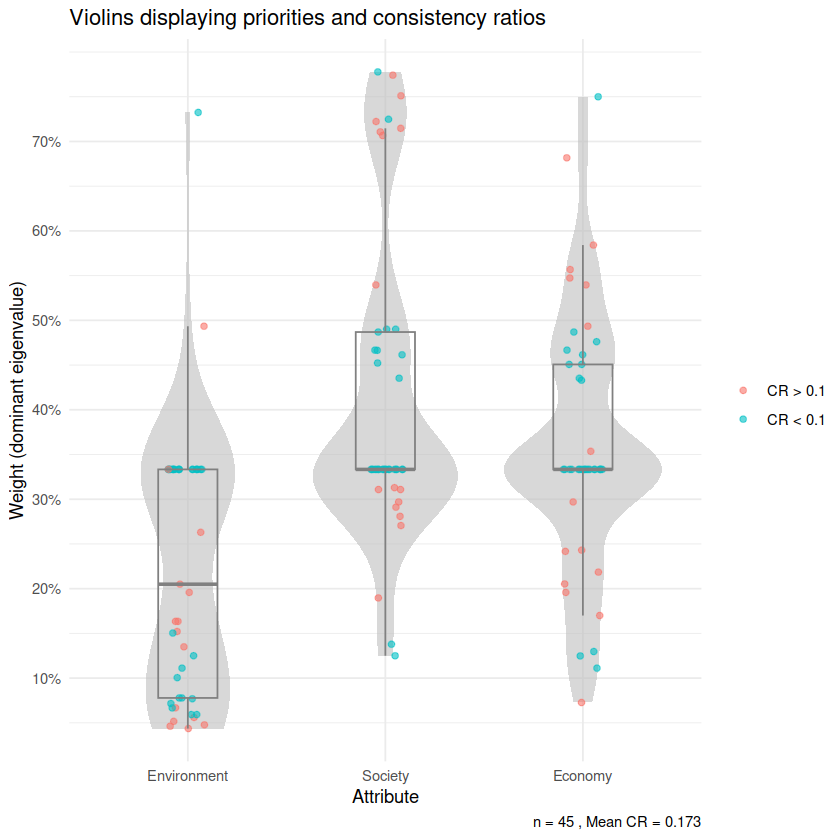

In [38]:
func_Process_ahpsurvey(df_csvInputFiles_NGO, "NGO", str_input_path, str_output_path, df_attributes_labels)

## Participants of practitioners and experts

[1] "ahp_violin_PE_env"
[1] "ahp_violin_PE_soc"
[1] "ahp_violin_PE_eco"


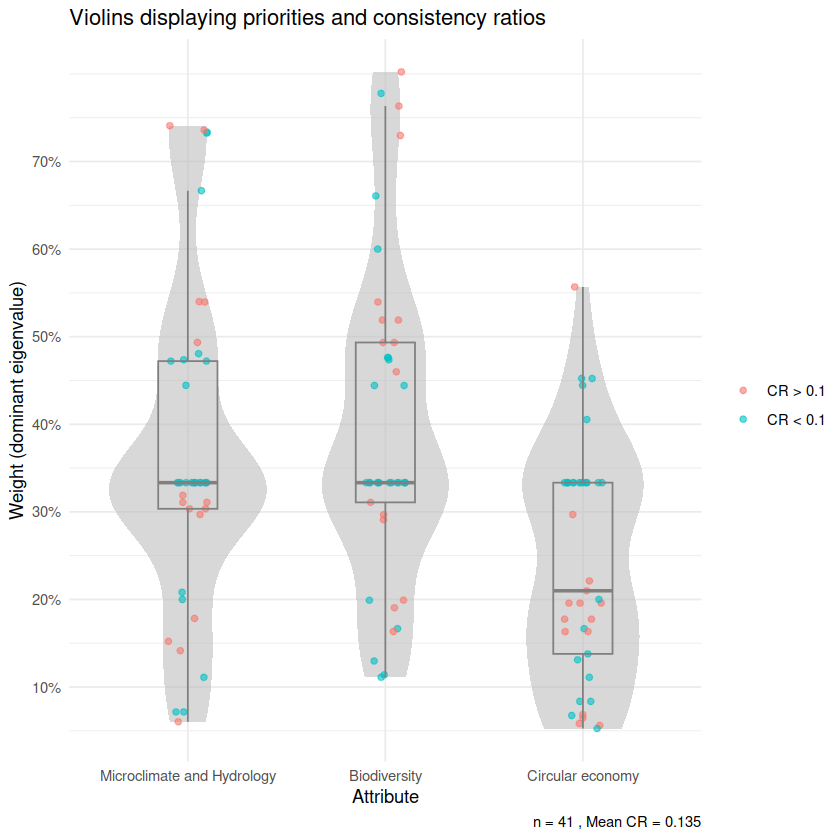

[1] "ahp_violin_PE_crit"


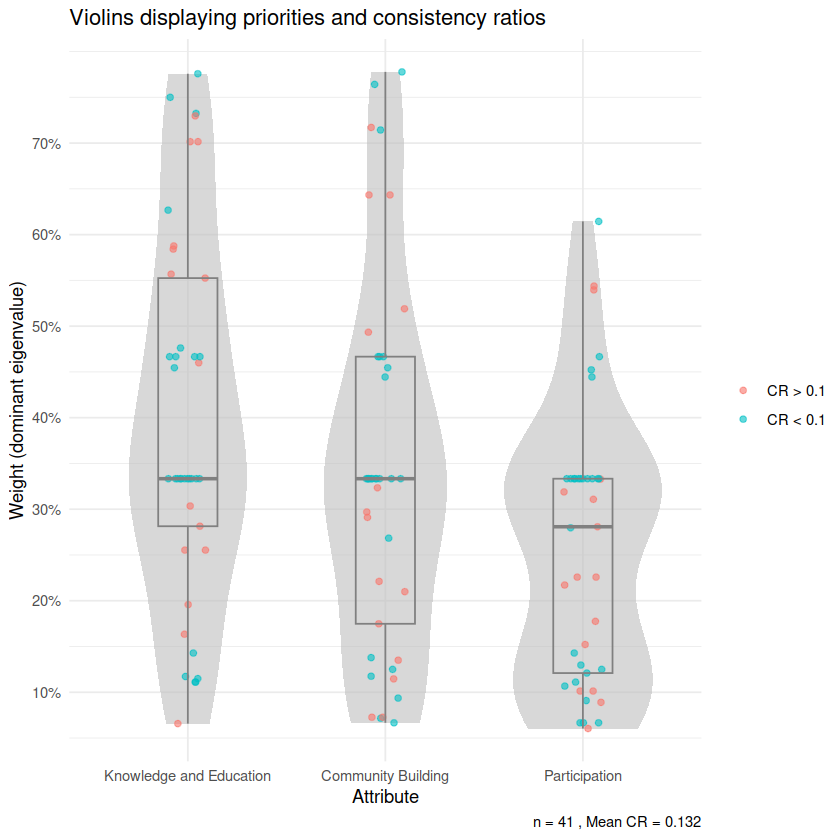

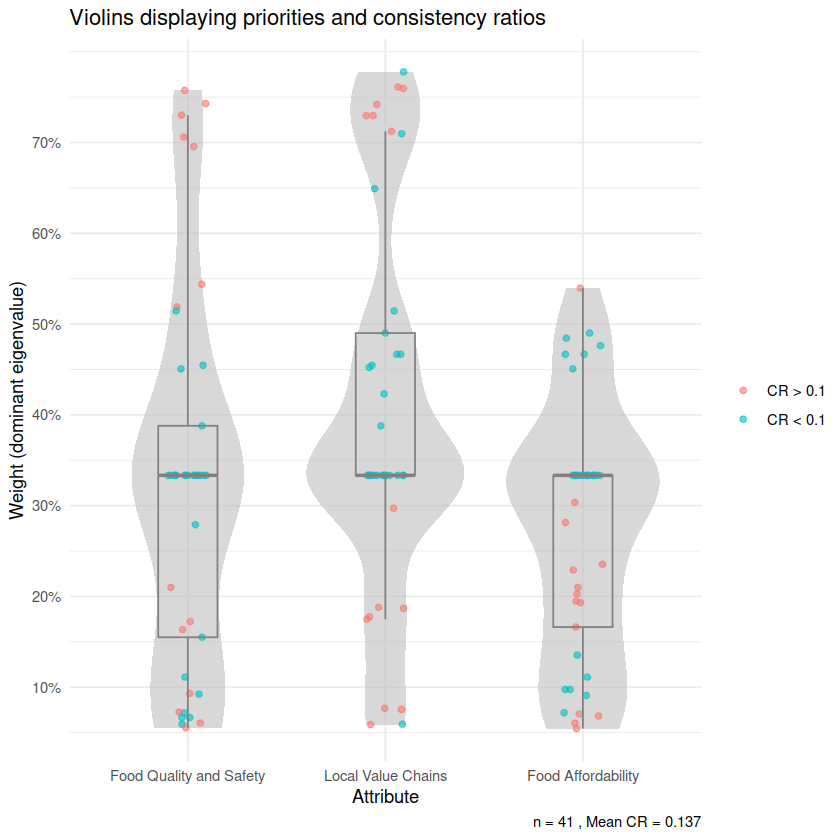

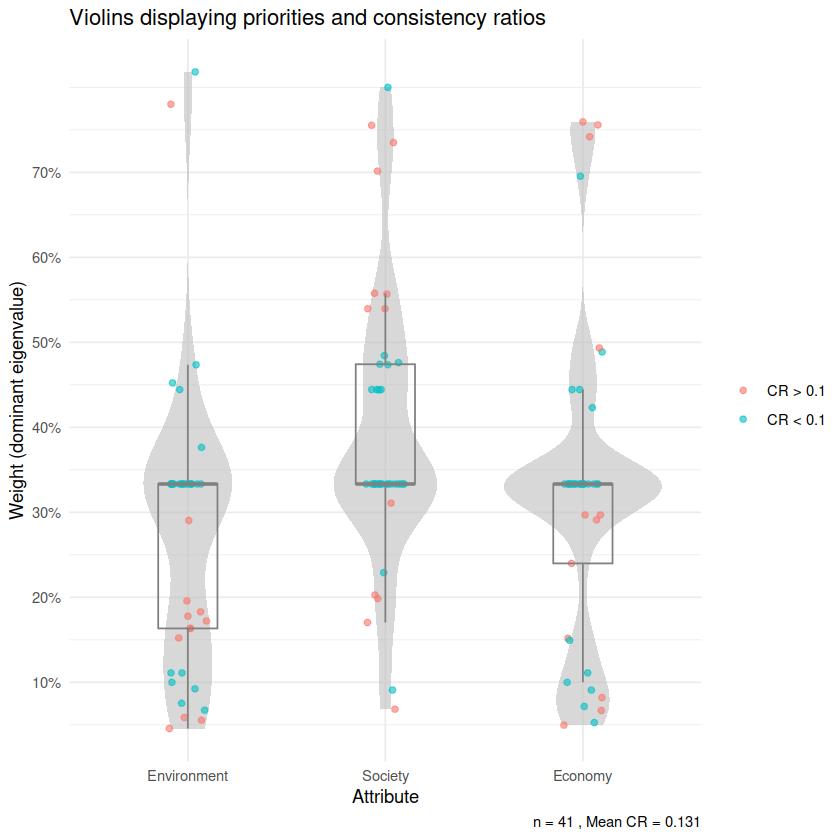

In [40]:
func_Process_ahpsurvey(df_csvInputFiles_PE, "PE", str_input_path, str_output_path, df_attributes_labels)

## Calculation of aggregated preference weights for consistent datasets

In [36]:
list_gmean <- func_aggpref_gmean(df_processed_survey_data, vec_atts, arr_CRs, consistency_thres=0.1, str_CRlabel)

df_gmean <- func_norm_gmean(list_gmean)

df_gmean

,gmean.raw,gmean.norm
,<dbl>,<dbl>
Envi,0.3739039,0.4179807
Soci,0.3023657,0.3380094
Econ,0.2182787,0.2440099
Sum,0.8945482,1.0000000


# Summary and outlook